# XGBOOST模型

## XGBOOST模型核心思想

**XGBOOST（Extreme Gradient Boosting）**，是一种基于梯度提升框架的Boosting模型。XGBOOST原理与GBDT模型类似，相比于GBDT模型，XGBOOST模型做了如下改进：
1. **正则化**：
    - GBDT模型没有显式的正则化机制，通常通过预先设置树的深度、叶子节点数等超参数的方法来控制树的复杂度，原始且不雅观。
    - XGBOOST在损失函数计算时即引入了 L1正则化（Lasso）和 L2正则化（Ridge）两种形式的正则化项，有助于控制模型的复杂度，并且能防止过拟合。L1正则化有助于特征选择，使得模型更加稀疏，而L2正则化则有助于模型平滑，避免过拟合。
2. **二阶导数的使用**：
    - GBDT模型使用一阶导数（梯度）来计算每一棵树的分裂点，从而最小化目标函数
    - XGBOOST模型同时使用一阶导数与二阶导数来计算树的分裂点。通过同时考虑一阶和二阶信息，XGBOOST模型能够更加精确地拟合损失函数，尤其是在处理复杂的非线性数据时，能够提高模型的稳定性和准确度
3. **树的构建方式（剪枝）**：
    - 传统的GBDT在树的生长过程中通过设置最大深度、最小样本分裂数等来防止过拟合，通常采用“预剪枝”（Pre-Pruning）的方法，即在树的生成过程中实时停止树的进一步分裂。
    - XGBoost采用了 后剪枝（Post-Pruning） 方法，即树构建完成后，再通过计算每个节点的增益来剪去那些不必要的部分，这样可以更加精细地控制树的复杂度。
4. **对缺失值的自动处理**：
    - GBDT无法处理缺失值，因此需要在建模之前预处理缺失值，例如通过填补缺失值或删除缺失数据来处理
    - XGBoost可以自动处理缺失值，在树的分裂过程中根据训练数据中缺失值的位置智能选择树的最佳分裂方向，从而避免了手动填补缺失值的麻烦，并且可以更好地利用缺失信息。
5. **更好处理类别特征**：
    - GBDT模型无法直接处理类别特征，需要预先对类别特征进行独热编码，从而导致高维稀疏特征矩阵，学习效率低下。
    - XGBOOST模型通过改进的分裂增益计算方法进一步优化了对类别特征的处理方式，可以选择最有意义的分裂点，从而提高了训练效率和模型性能。
6. **并行化与加速**：
    - GBDT在构建每棵树时是一个顺序过程，通常是逐层逐节点进行生成。每一轮的树生成依赖于前一轮的误差，这使得它无法进行有效的并行化
    - XGBoost在训练过程中可以进行 并行化，特别是在树的每个分裂点上，它采用了 特征并行 和 数据并行 的方式。每一棵树的分裂过程可以在不同的处理器核上并行计算，从而显著加速训练过程

## XGBOOST模型主要步骤

XGBOOST模型的主要步骤概括如下：

1. **初始化**：
    - 首先，XGBOOST模型会用一个简单的模型（如常数模型）对所有样本做出初始预测。
2. **迭代优化**：
    - **计算残差**：基于当前模型的预测结果，计算每个样本的真实标签与预测值之间的梯度（对于回归问题通常是真实值减去预测值；对于分类问题，则使用损失函数的负梯度）。
    - **拟合决策树**：将这些残差作为新的目标变量，训练一个决策树来拟合这些残差。
    - **更新预测**：将新训练的决策树加入到模型中，更新每个样本的预测值为原预测值加上新决策树的输出。
    - **重复上述过程**，直到达到预设的迭代次数或满足停止条件。
3. **构建最终模型**：
    - 所有决策树的加权预测结果组合起来，形成最终的强学习器。

## XGBOOST模型优缺点

### XGBOOST模型的优点

- **高效的计算性能**：XGBoost支持并行处理，在每个节点的分裂计算中，能够利用多核CPU加速树的构建。同时XGBoost支持GPU加速训练，XGBoost在训练速度上相比其他梯度提升树实现有显著优势
- **高准确性与强大的性能**：
    - XGBoost结合了 梯度提升 和 L1、L2正则化，能够有效地减少过拟合，具有较强的泛化能力
    - XGBoost的 树结构优化（如后剪枝、深度限制、最小增益等）使得模型在复杂数据集上表现出色，通常能够达到非常高的准确度
- **自动处理缺失值**：XGBoost能自动处理缺失值，在每一轮迭代中会选择最佳的分裂方式来处理缺失数据，这减少了需要额外处理缺失数据的麻烦。

### XGBOOST模型的缺点

- **处理类别特征的效率较低**：XGBoost虽然支持类别特征，但与其他算法（如CatBoost、LightGBM）相比， 对类别特征的处理较为繁琐，需要进行额外的编码或转换（如目标编码或独热编码），而这些方法可能会导致特征空间的维度爆炸，增加计算复杂度
- **对噪音敏感**：XGBOOST模型的高准确性导致其对噪音数据非常敏感，尤其是在训练集包含异常值或错误标注的情况下，容易导致模型过拟合。因此建模前的数据清洗与特征工程非常重要
- **对超参数调节敏感**：XGBoost的性能很大程度上依赖于超参数调节。选择合适的学习率、树的深度、正则化参数等非常关键。如果调参不当，模型可能会过拟合或欠拟合。因此最好使用交叉验证或网格搜索等方法来帮助XGBOOST模型选择最优超参数

# XGBOOST模型案例（多分类）

## xgboost模型参数

### params参数

- **objective**: 目标函数
    - 二分类: 'binary:logistic'（输出为概率）
    - 多分类: 'multi:softmax'（输出为类别索引，需配合 num_class 使用）
    - 多分类: 'multi:softprob'（输出为类别概率，需配合 num_class 使用）
    - 回归: 'reg:squarederror'（均方误差）
        
- **eval_metric**：评估指标
    - 二分类: 'auc'、'logloss'
    - 多分类: 'mlogloss'
    - 回归: 'rmse'（均方根误差）、'mae'（平均绝对误差）
- **num_class**: 多分类类别数（仅多分类任务使用）。
- **max_depth**: 决策树的最大深度。控制模型复杂度，值越大模型越容易过拟合。
- **gamma**: 后剪枝参数，用于控制是否分裂节点。值越大越保守（避免过拟合），常设为 0.1 或 0.2。
- **min_child_weight**: 最小叶子节点样本的权重和。值越大越保守（防止学习到噪声），值过大会导致欠拟合。
- **alpha**: L1 正则化项系数。
- **lambda**: L2 正则化项系数。
- **subsample**: 每棵树训练时所使用的样本比例（行采样）。值小于 1 可降低方差，防止过拟合。常用值：0.8。
- **colsample_bytree**: 构建每棵树时所采样的特征比例（列采样）。常用值：0.8。
- **eta**: 学习率，控制每棵树对最终结果的影响，值越小训练越慢但更稳定。通常设置在 0.01 到 0.3 之间。  
- **n_jobs**: 指定并行线程数，-1 表示使用所有可用线程。  
- **verbosity**: 控制训练过程输出。
    - 0：输出全部信息
    - 1：输出警告信息
    - 2：输出详细信息
    - 3：仅输出致命错误  
- **seed**: 随机数种子。    

### xgb.train参数

- **params**: 2.1.1节中params参数，dict格式
- **dtrain**: 训练数据，DMatrix 格式，包含特征和标签。
- **num_boost_round**: 训练轮数，也即树的棵树。
- **evals**: 验证集列表，格式为[(dvalid, 'eval')]
- **feval**: 自定义评估函数，返回 (名称, 分数)，如 F1、精确率、召回率等。
- **early_stopping_rounds**: 早停参数。若验证指标在指定轮数内没有提升，则提前停止训练。必须搭配 evals 使用。
- **verbose_eval**: 训练信息输出轮数。设为整数如 10 表示每 10 轮输出一次。
- **xgb_model**: 用于加载已有模型，进行继续训练或 warm start。可接收None、路径、Booster对象等。
    - 已有模型路径
    - 已训练的 Booster 对象
    - None 表示从头开始
- **obj**: 自定义目标函数，用于替换默认 loss。

## 手写数字识别digits数据集

digits数据集是一个经典的手写数字图像识别数据集，任务是根据图像的特征预测图像所代表的数字标签
- 这个数据集总共有1797个图像样本：
    - 每个图像是一个 8x8 的灰度图像，其每个像素的灰度值范围为 0 到 16，表示黑色（0）到白色（16）。这些图像已经被展平为 64 维的向量，因此每个图像可以表示为一个长度为 64 的向量
    - 数字标签的范围是从 0 到 9，对应的是手写数字
- 这个数据集由以下组成
    - data：一个数组，形状为 (1797, 64)，每一行表示一个 8x8 图像的特征（64个像素值，表示灰度强度）。
    - target：一个数组，形状为 (1797,)，每个元素表示相应图像的标签（0到9之间的数字）。
    - target_names：一个数组，表示数字标签的类别名，通常是 [0, 1, 2, ..., 9]。
    - images：一个数组，形状为 (1797, 8, 8)，每个元素是一个 8x8 的数字图像矩阵。
    - DESCR：一个字符串，包含数据集的描述信息。

In [1]:
# 导入必要的库
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# 加载 digits 数据集
digits = load_digits()
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

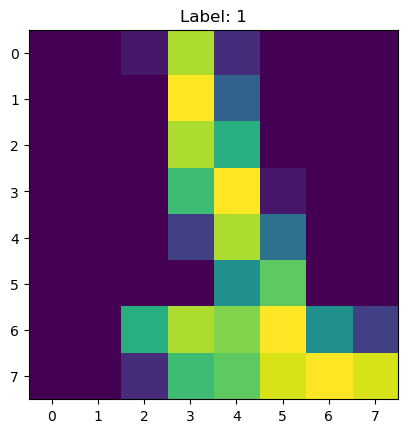

In [2]:
# 绘制数字图像
idx=1000
plt.imshow(digits.images[idx])
plt.title(f'Label: {digits.target[idx]}')
plt.show()

## 代码实现

xgboost的版本: 2.1.3

[0]	train-mlogloss:2.17419	train-merror:0.05846	test-mlogloss:2.18961	test-merror:0.20000
[50]	train-mlogloss:0.41454	train-merror:0.00070	test-mlogloss:0.61360	test-merror:0.05278
[100]	train-mlogloss:0.11717	train-merror:0.00000	test-mlogloss:0.30435	test-merror:0.04167
[114]	train-mlogloss:0.08535	train-merror:0.00000	test-mlogloss:0.26646	test-merror:0.04167


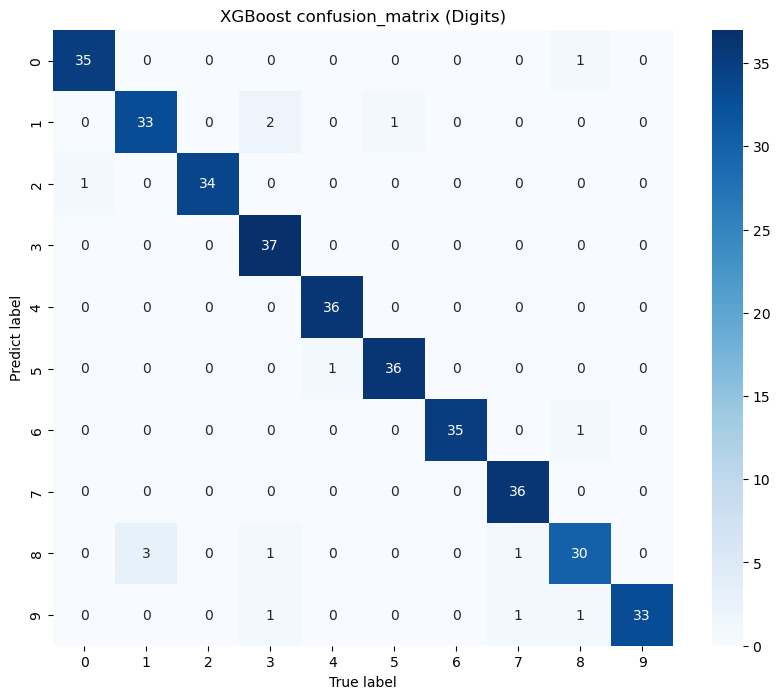

Classification Report:
              precision    recall  f1-score   support

           0     0.9722    0.9722    0.9722        36
           1     0.9167    0.9167    0.9167        36
           2     1.0000    0.9714    0.9855        35
           3     0.9024    1.0000    0.9487        37
           4     0.9730    1.0000    0.9863        36
           5     0.9730    0.9730    0.9730        37
           6     1.0000    0.9722    0.9859        36
           7     0.9474    1.0000    0.9730        36
           8     0.9091    0.8571    0.8824        35
           9     1.0000    0.9167    0.9565        36

    accuracy                         0.9583       360
   macro avg     0.9594    0.9579    0.9580       360
weighted avg     0.9593    0.9583    0.9582       360



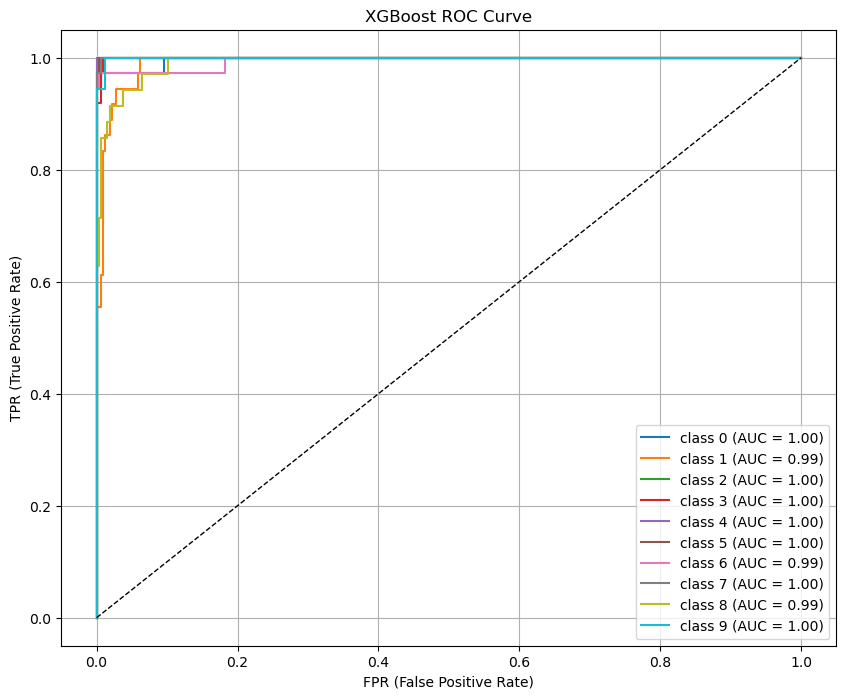

In [3]:
# 加载 digits 手写数字数据集（0~9 共10类）
X = digits.data               # 64维度特征（8x8 像素图像）
y = digits.target             # 对应数字标签（整数 0-9）
class_names = digits.target_names  # [0, 1, ..., 9]

# 划分训练集和验证集，20% 用于验证
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 将训练数据转换为 XGBoost 专用格式 DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 设置 XGBoost 多分类参数
params = {
    'objective': 'multi:softprob',   # 多分类任务，输出类别概率
    'num_class': 10,                # 类别数量（digits 有 10 类）
    'eval_metric': ['mlogloss', 'merror'],  # 多分类对数损失和错误率
    'max_depth': 6,                 # 树的最大深度
    'gamma': 0.2,                   # 后剪枝参数
    'min_child_weight': 1,          # 最小叶子节点样本权重和
    'alpha': 0,                     # L1 正则化系数
    'lambda': 0,                    # L2 正则化系数
    'subsample': 0.8,               # 行采样比例
    'colsample_bytree': 0.8,        # 列采样比例
    'eta': 0.03,                     # 学习率
    'n_jobs': -1,                   # 使用所有CPU核心
    'verbosity': 1,                 # 输出警告信息
    'seed': 42                      # 固定随机种子
}

# 训练模型
model = xgb.train(
    params=params,                  # 参数字典
    dtrain=dtrain,                  # 训练集
    num_boost_round=1000,          # 最多训练 1000 轮
    evals=[(dtrain, 'train'), (dtest, 'test')],  # 监控训练和验证集效果
    early_stopping_rounds=50,      # 如果 50 轮无提升就提前停止
    verbose_eval=50,               # 每 50 轮输出一次指标
    xgb_model=None,                # 不使用已有模型
    obj=None,                      # 不使用自定义目标函数
    feval=None                     # 不使用自定义评估函数
)

# 预测验证集每个样本属于每一类的概率（返回 [n_samples, 10] 的数组）
y_prob = model.predict(dtest)

# 对每个样本，取概率最大的索引作为预测类别
y_pred = np.argmax(y_prob, axis=1)

# ==== 混淆矩阵可视化 ====
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("XGBoost confusion_matrix (Digits)")
plt.xlabel("True label")
plt.ylabel("Predict label")
plt.show()

# ==== 分类评估报告 ====
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ==== 每类 ROC 曲线和 AUC ====
# 初始化字典保存每类 FPR、TPR、AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)

# 对测试标签进行二值化，用于多类别 ROC
# 例如: 3 -> [0 0 0 1 0 0 0 0 0 0]
y_test_bin = label_binarize(y_test, classes=class_names)

# 对每个类别分别计算 ROC 曲线
for i in range(n_classes):
    # y_test_bin[:, i] 为该类别的真实标签（0或1）
    # y_prob[:, i] 为模型预测该类的概率
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制多类别 ROC 曲线
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f'class {i} (AUC = {roc_auc[i]:.2f})',
             color=colors(i))

# 参考线
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("XGBoost ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# XGBOOST可视化

## xgb.plot_tree

**xgb.plot_tree**: 生成直观的XGBOOST树形结构图
- `booster`: 训练好的XGBOOST模型
- `num_trees`: 要绘制第几棵树（从 0 开始），可用循环遍历多棵树
- `rankdir`: 决定图的布局方向：
    - `TB`：从上到下（默认）
    - `LR`：从左到右（推荐更清晰）

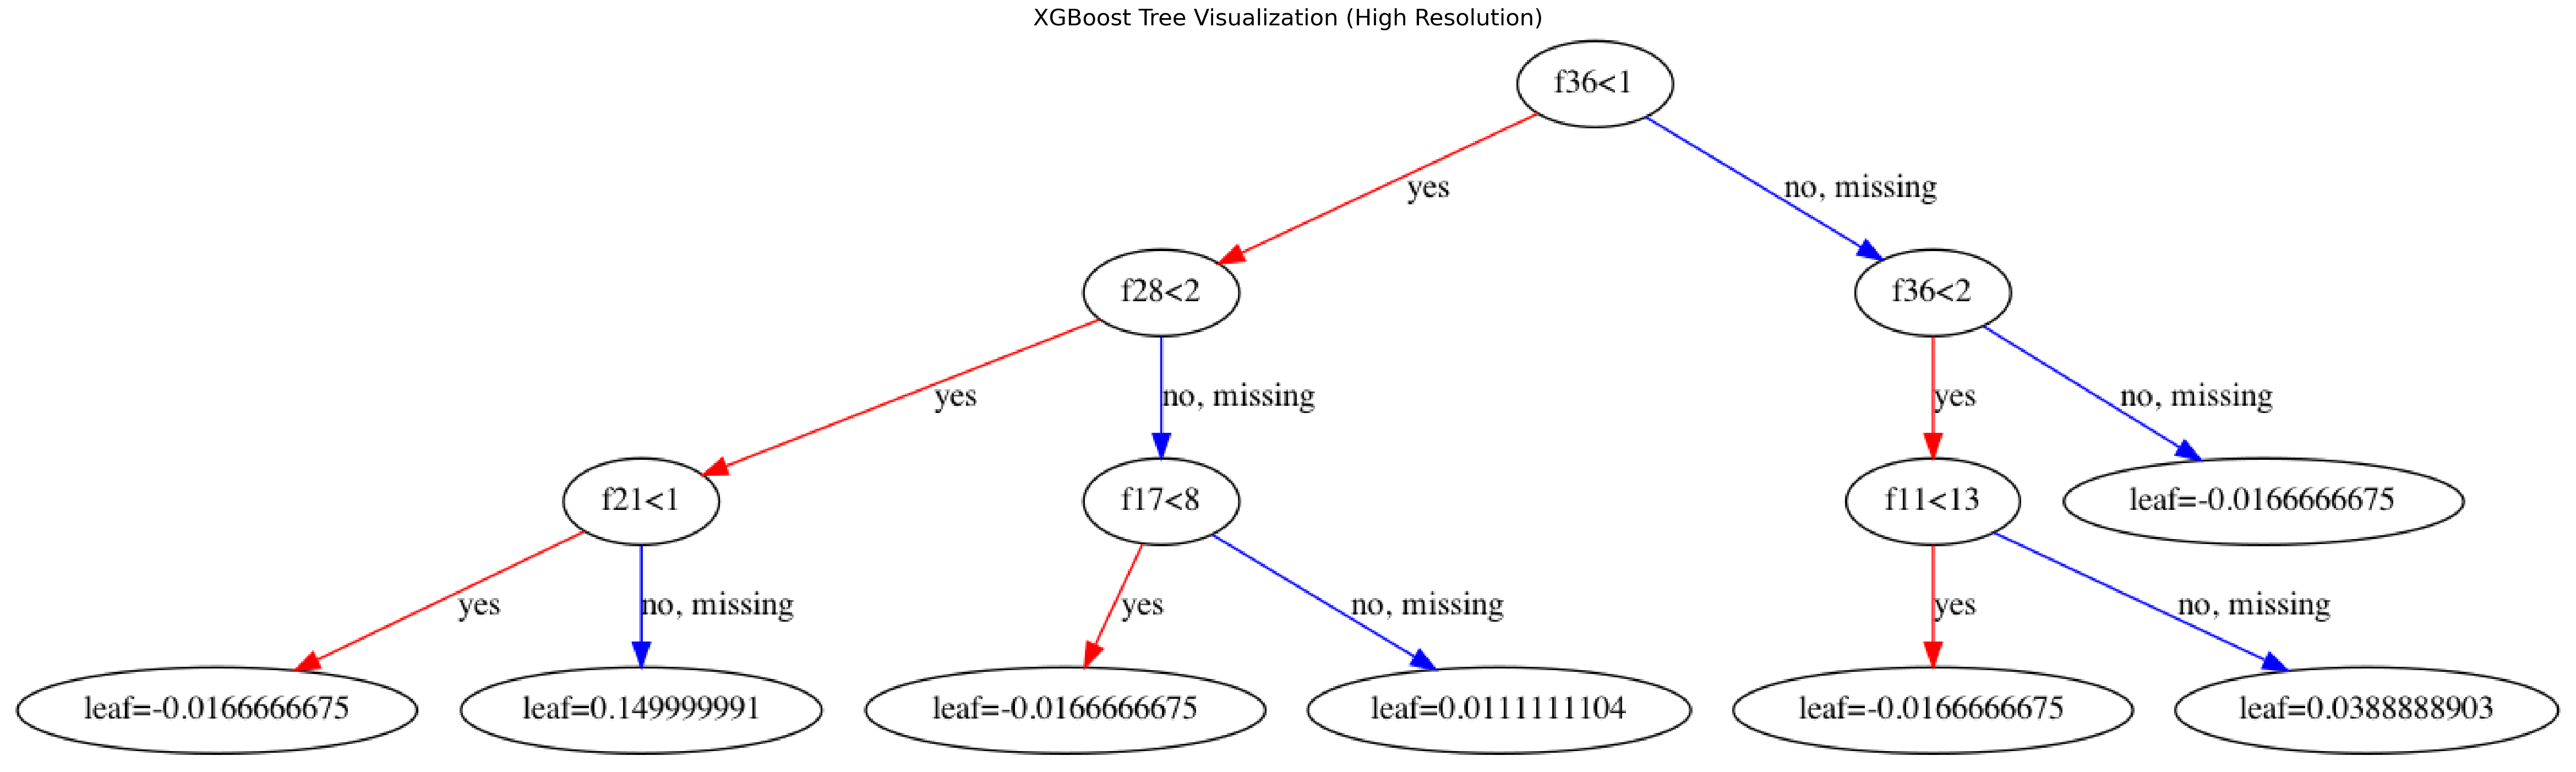

In [4]:
import matplotlib.pyplot as plt
import xgboost as xgb

# 提高分辨率的方法：设置图像大小 + DPI
fig, ax = plt.subplots(figsize=(40, 30), dpi=150)  # 更大尺寸 + 更高清
xgb.plot_tree(model, num_trees=0, ax=ax)
plt.title("XGBoost Tree Visualization (High Resolution)", fontsize=20)
plt.show()

# 特征重要度

在 XGBoost 中，特征重要性用于衡量每个特征在提升模型性能方面的贡献程度。由于 XGBoost 是一个基于梯度提升（Gradient Boosting）的集成学习算法，它通过不断构建新的决策树来优化目标损失函数，因此每个特征在不同树中分裂所带来的“损失下降”或“划分次数”可被量化为重要性。

## XGBoost 中的特征重要性计算方式

XGBoost 提供 三种主要的特征重要性指标，分别是：

| 指标类型     | 含义说明                         |
| -------- | ---------------------------- |
| `weight` | 某特征在所有树中被用作分裂的总次数（频率）        |
| `gain`   | 每次使用该特征分裂所带来的平均损失函数下降量（信息增益） |
| `cover`  | 使用该特征进行分裂时所覆盖的样本的平均数量或权重     |


## weight（分裂频次 / 使用次数）

- **定义**：某特征在所有树中被用作分裂节点的次数总和。 
    - 如果一个特征频繁出现在树的节点中，说明它对树的划分有广泛的贡献。 
    - 但它不考虑每次分裂的“质量”（是否带来显著增益）。 
- **计算公式**：
$$\text{Importance}_j^{(\text{weight})} = \sum_{m=1}^{M} \sum_{t \in T_m} \mathbb{1}(j = \text{feature}(t)) $$
其中：
    - $M$：总树数（boosting round） 
    - $T_m$：第$m$棵树的所有非叶节点集合 
    - $\mathbb{1}(j = \text{feature}(t))$：如果节点$t$使用了特征$j$进行划分，则为 1，否则为 0 
- **优点**：
    - 简单直观，易于解释。 
- **缺点**：
    - 可能会高估“常被选中但增益较低”的特征。 
    - 不考虑特征实际提升模型性能的程度。 
- **适合场景**：
    - 初步筛选特征（例如是否经常被使用）。 

## gain（平均信息增益，推荐）

- **定义**：某特征被用来分裂时，对模型损失函数（如 logloss, mse）带来的平均下降量（即平均提升）。 
    - 更关注“质量”而不是“次数”，代表该特征“每次使用是否有价值”。 
    - 通常是更可靠的特征重要性衡量标准。 
- **计算公式**：
$$\text{Importance}_j^{(\text{gain})} = \sum_{m=1}^{M} \sum_{t \in T_m} \Delta \mathcal{L}_t \cdot \mathbb{1}(j = \text{feature}(t)) $$
其中：
    - $M$：总树数（boosting round） 
    - $T_m$：第$m$棵树的所有非叶节点集合 
    - $\Delta \mathcal{L}_t$：节点$t$分裂带来的 损失函数下降（loss reduction）
    - $\mathbb{1}(j = \text{feature}(t))$：如果节点$t$使用了特征$j$进行划分，则为 1，否则为 0 
- **优点**：
    - 与模型性能直接相关。 
    - 强调了特征的“实际贡献”。 
- **缺点**：
    - 在样本不平衡或分裂稳定性差时可能波动较大。 
- **适合场景**：
    - 高质量特征排序、模型解释、业务特征分析。 

## cover（样本覆盖度）

- **定义**：某特征被用来分裂的所有节点中，涉及的样本数或权重的平均值。 
    - 说明这个特征倾向于影响“更多的数据点”。 
    - 例如某特征在靠近树根部被使用（覆盖样本多），其 cover 可能较高。 
- **计算公式**：
$$\text{Importance}_j^{(\text{cover})} = \sum_{m=1}^{M} \sum_{t \in T_m} h_t \cdot \mathbb{1}(j = \text{feature}(t))$$
其中：
    - $M$：总树数（boosting round） 
    - $T_m$：第$m$棵树的所有非叶节点集合 
    - $h_t$：分裂节点$t$所覆盖的样本数量或样本权重 
    - $\mathbb{1}(j = \text{feature}(t))$：如果节点$t$使用了特征$j$进行划分，则为 1，否则为 0 
- **优点**：
    - 可以识别影响范围广的特征。 
- **缺点**：
    - 不能单独反映特征的分裂质量（增益大小）。 
    - 可能高估冗余但出现在根节点的特征。 
- **适合场景**：
    - 分析哪些特征影响了“广泛人群”，辅助业务覆盖决策。 

## 特征重要度代码实现与可视化

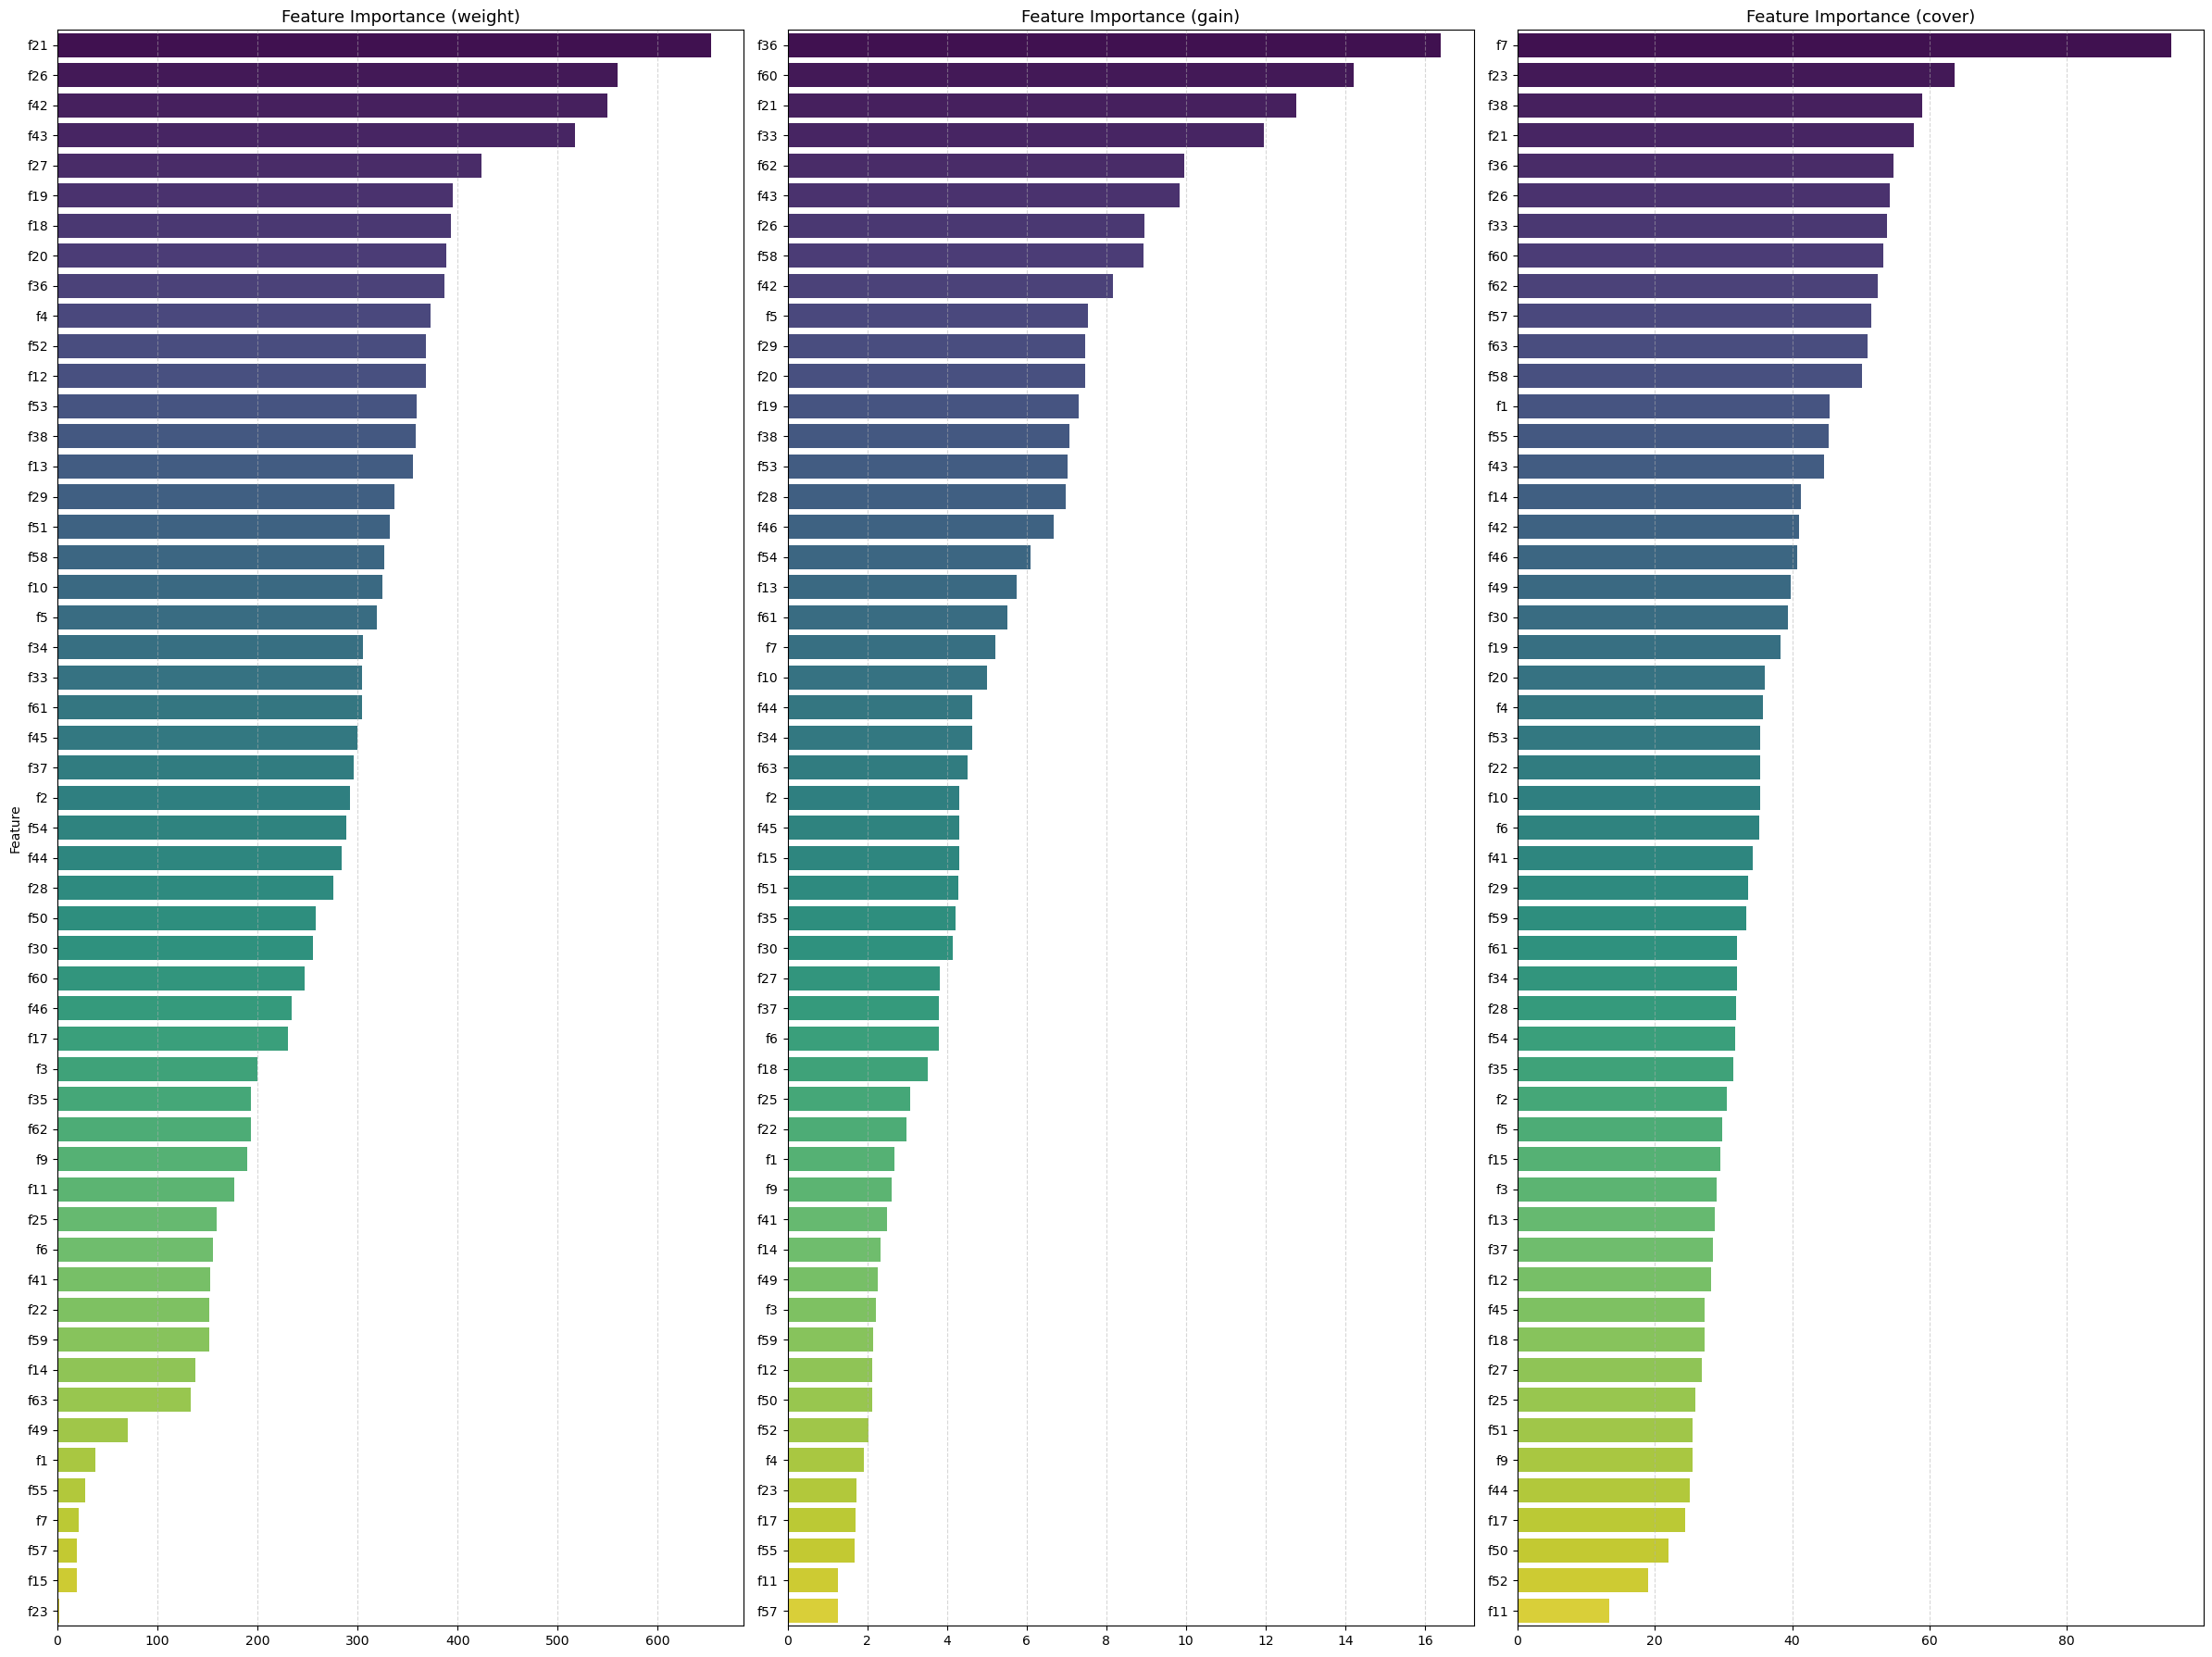

In [6]:
# 三种重要性指标
importance_types = ['weight', 'gain', 'cover']
importance_data = {}

for imp_type in importance_types:
    imp_dict = model.get_score(importance_type=imp_type)
    # 映射为原始特征名
    imp_df = pd.DataFrame({
        'Feature': list(imp_dict.keys()),
        'Importance': list(imp_dict.values())
    }).sort_values('Importance', ascending=False)
    importance_data[imp_type] = imp_df

# 绘制子图
fig, axes = plt.subplots(1, 3, figsize=(24, 18))
for i, imp_type in enumerate(importance_types):
    sns.barplot(
        ax=axes[i],
        data=importance_data[imp_type],
        x='Importance',
        y='Feature',
        palette='viridis'
    )
    axes[i].set_title(f'Feature Importance ({imp_type})', fontsize=13)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('' if i > 0 else 'Feature')
    axes[i].grid(True, axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()